In [ ]:
import numpy as np
import pickle
import cv2
import tensorflow
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d emmarex/plantdisease

100% 655M/658M [00:32<00:00, 22.1MB/s]
100% 658M/658M [00:32<00:00, 21.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plantdisease.zip', 'r')
zip_ref.extractall('/content/input')
zip_ref.close()

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/input/plantvillage'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
print(image_size)

2951


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print(np_image_list)

[[[[0.88    0.849   0.9067 ]
   [0.7646  0.7334  0.791  ]
   [0.8047  0.7734  0.831  ]
   ...
   [0.947   0.933   1.     ]
   [0.933   0.92    0.987  ]
   [0.6846  0.671   0.738  ]]

  [[0.92    0.8887  0.947  ]
   [0.7954  0.7646  0.8223 ]
   [0.933   0.9023  0.96   ]
   ...
   [0.8     0.7866  0.8535 ]
   [0.8047  0.791   0.858  ]
   [0.778   0.7646  0.831  ]]

  [[0.742   0.711   0.769  ]
   [0.7954  0.7646  0.8223 ]
   [0.9023  0.871   0.9287 ]
   ...
   [0.844   0.831   0.898  ]
   [0.7734  0.76    0.8267 ]
   [0.8354  0.8223  0.8887 ]]

  ...

  [[0.8936  0.8667  0.9155 ]
   [0.8887  0.8623  0.911  ]
   [0.8887  0.8623  0.911  ]
   ...
   [0.92    0.9023  0.951  ]
   [0.92    0.9023  0.951  ]
   [0.9243  0.9067  0.9556 ]]

  [[0.9155  0.8887  0.938  ]
   [0.9023  0.8755  0.9243 ]
   [0.8887  0.8623  0.911  ]
   ...
   [0.933   0.9155  0.9644 ]
   [0.933   0.9155  0.9644 ]
   [0.9424  0.9243  0.973  ]]

  [[0.933   0.9067  0.9556 ]
   [0.9155  0.8887  0.938  ]
   [0.898   0.871   

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Replace 'n_classes' with the number of output classes
model.add(Dense(n_classes))
model.add(Activation("softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
opt = Adam(learning_rate=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
73/73 [==============================] - 59s 568ms/step - loss: 0.6379 - accuracy: 0.2350 - val_loss: 0.2974 - val_accuracy: 0.0745
Epoch 2/25
73/73 [==============================] - 40s 550ms/step - loss: 0.2286 - accuracy: 0.4467 - val_loss: 0.4277 - val_accuracy: 0.0728
Epoch 3/25
73/73 [==============================] - 39s 530ms/step - loss: 0.2075 - accuracy: 0.4832 - val_loss: 0.4975 - val_accuracy: 0.1540
Epoch 4/25
73/73 [==============================] - 39s 537ms/step - loss: 0.1994 - accuracy: 0.5172 - val_loss: 0.4354 - val_accuracy: 0.1100
Epoch 5/25
73/73 [==============================] - 39s 532ms/step - loss: 0.1528 - accuracy: 0.6400 - val_loss: 0.4085 - val_accuracy: 0.2183
Epoch 6/25
73/73 [==============================] - 38s 512ms/step - loss: 0.1273 - accuracy: 0.6873 - val_loss: 0.3390 - val_accuracy: 0.2352
Epoch 7/25
73/73 [==============================] - 38s 525ms/step - loss: 0.1130 - accuracy: 0.7298 - val_loss: 0.2763 - val_accuracy: 0.3587

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 25, 'steps': 73}


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


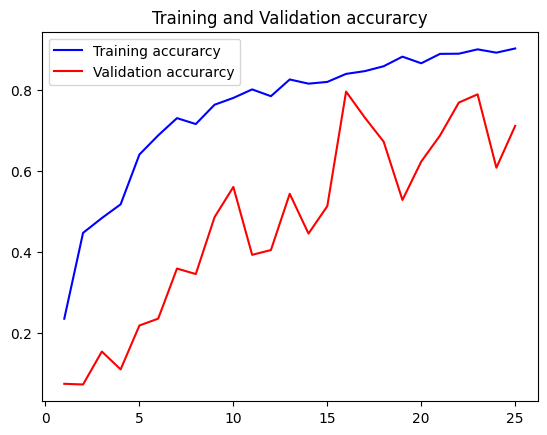

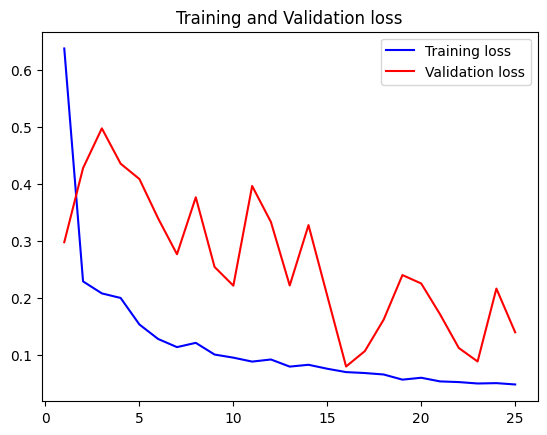

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 33ms/step - loss: 0.1391 - accuracy: 0.7107
Test Accuracy: 71.0659921169281


In [ ]:
print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))
model.save("cnn_model")

[INFO] Saving model...


In [ ]:
loaded_model = load_model("cnn_model")

In [ ]:
!zip -r '/content/my_model.zip' '/content/cnn_model'

  adding: content/cnn_model/ (stored 0%)
  adding: content/cnn_model/variables/ (stored 0%)
  adding: content/cnn_model/variables/variables.index (deflated 71%)
  adding: content/cnn_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/cnn_model/saved_model.pb (deflated 89%)
  adding: content/cnn_model/fingerprint.pb (stored 0%)
  adding: content/cnn_model/keras_metadata.pb (deflated 94%)
  adding: content/cnn_model/assets/ (stored 0%)


In [ ]:
image_dir="/content/input/PlantVillage"

folder_names = listdir(image_dir)
# print(images_dir)

for folder_name in folder_names:
  # print(folder_name)
  images = listdir(f"{image_dir}/{folder_name}")
  # print(images)

print(images)
image_location = f"{image_dir}/{folder_name}/{images[2]}"
im=convert_image_to_array(image_location)
print(im)
np_image_li = np.array(im, dtype=np.float16) / 225.0
print(np_image_li)
npp_image = np.expand_dims(im, axis=0)
print(npp_image)

['5b09c1a9-f5ca-4c26-a627-a6ac6b2045cb___PSU_CG 2247.JPG', 'b8972ee2-b576-4fdd-bb69-f8c43b87471b___PSU_CG 2060.JPG', '67662638-1bfa-4ff6-8305-2d8544277ef0___PSU_CG 2222.JPG', '5ecb9930-250d-4fac-9547-e3b5142eec46___PSU_CG 2164.JPG', 'a4453e9a-4ede-4377-be38-fd77e9bf16f0___PSU_CG 2308.JPG', 'b455e70e-1ff9-4081-a0bb-6d16c88402e3___PSU_CG 2105.JPG', '69726f1b-4d1c-4647-aef2-090e57246501___PSU_CG 2131.JPG', '4571a1c4-3a67-4437-a5bf-8bc1a2af22e4___PSU_CG 2360.JPG', 'cc8059de-bae3-4ace-b6a5-f12a07fef342___PSU_CG 2410.JPG', '3117475d-3948-45a5-b2c7-630efb8bfab8___PSU_CG 2333.JPG', 'd8106a03-3742-4e57-9ea7-d634b56c76cf___PSU_CG 2265.JPG', 'da1583ac-e469-400a-9092-da870299fd35___PSU_CG 2071.JPG', '75c566a5-8c20-4294-8138-4f06a3c2df7c___PSU_CG 2158.JPG', '0c779116-043c-4715-b080-16be2e8d2552___PSU_CG 2285.JPG', 'c1ff629a-8390-43a4-88ed-86e462d688a7___PSU_CG 2083.JPG', '5ab64087-b61c-48b9-9db7-5c6ce3eeefcd___PSU_CG 2299.JPG', '696758e5-0f10-4599-b596-e9e7566c4791___PSU_CG 2062.JPG', 'b23eb7f0-daa

In [ ]:
result = loaded_model.predict(npp_image)

print(result)

1/1 [==============================] - 0s 20ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:1.0
Tomato_Septoria_leaf_spot
